In [83]:
import os
import matplotlib
from matplotlib import pyplot as plt
%matplotlib
from astropy import visualization
from astropy.time import Time
from astropy.io import fits
import numpy as np

import connect_to_sndavis
import spectroscopy

Using matplotlib backend: Qt5Agg


In [2]:
db, cursor = connect_to_sndavis.get_cursor()

# See if there is a natural break in slope between IIL and IIP

In [3]:
query_allII = "SELECT snslope.slope FROM snslope \
JOIN supernovanames ON snslope.`targetid`=supernovanames.`targetid` \
JOIN idsupernovae ON supernovanames.`targetid`=idsupernovae.`id` \
WHERE idsupernovae.`sntype` IN (6,17,18) AND \
snslope.`slopetype`='s50' AND \
snslope.filter='V'"

In [4]:
cursor.execute(query_allII)
results_allII = cursor.fetchall()

In [5]:
slope_allII = np.array([idict['slope'] for idict in results_allII])
slope_per_100d_allII = slope_allII*100

In [6]:
query_IIL = "SELECT snslope.slope FROM snslope \
JOIN supernovanames ON snslope.`targetid`=supernovanames.`targetid` \
JOIN idsupernovae ON supernovanames.`targetid`=idsupernovae.`id` \
WHERE idsupernovae.`sntype` = 18 AND \
snslope.`slopetype`='s50' AND \
snslope.filter='V'"

In [7]:
cursor.execute(query_IIL)
results_IIL = cursor.fetchall()

In [8]:
slope_IIL = np.array([idict['slope'] for idict in results_IIL])
slope_per_100d_IIL = slope_IIL*100

Text(0,0.5,'Number')

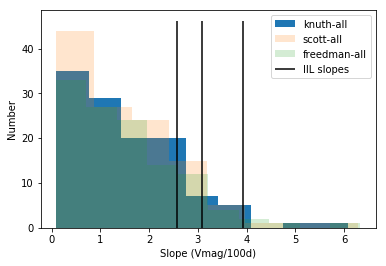

In [9]:
visualization.hist(slope_per_100d_allII, bins='knuth', label='knuth-all')
visualization.hist(slope_per_100d_allII, bins='scott', alpha=0.2, label='scott-all')
visualization.hist(slope_per_100d_allII, bins='freedman', alpha = 0.2, label='freedman-all')
plt.vlines(slope_per_100d_IIL, ymin=plt.ylim()[0], ymax=plt.ylim()[1], label='IIL slopes')
plt.legend()
plt.xlabel('Slope (Vmag/100d)')
plt.ylabel('Number')


Text(0,0.5,'Number')

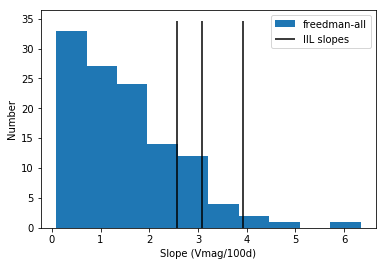

In [10]:
visualization.hist(slope_per_100d_allII, bins='freedman',  label='freedman-all')
plt.vlines(slope_per_100d_IIL, ymin=plt.ylim()[0], ymax=plt.ylim()[1], label='IIL slopes')
plt.legend()
plt.xlabel('Slope (Vmag/100d)')
plt.ylabel('Number')

Text(0,0.5,'Number')

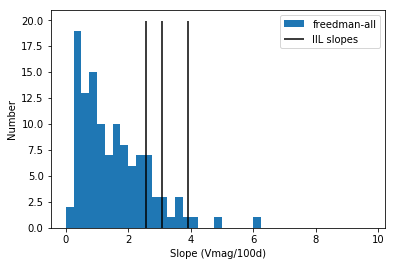

In [11]:
plt.hist(slope_per_100d_allII, bins=np.arange(0,10, 0.25),  label='freedman-all')
plt.vlines(slope_per_100d_IIL, ymin=plt.ylim()[0], ymax=plt.ylim()[1], label='IIL slopes')
plt.legend()
plt.xlabel('Slope (Vmag/100d)')
plt.ylabel('Number')

# Nope, let's just see if what we have spectroscopically and color by slope

In [111]:
spectra_query = '''
SELECT idsupernovae.`jdexpl`, supernovanames.`name`, spectra.`dateobs`, spectra.`filepath`, spectra.`filename`, snslope.`slope`
FROM idsupernovae JOIN supernovanames ON idsupernovae.`id` = supernovanames.`targetid`
JOIN spectra ON idsupernovae.`id` = spectra.`targetid`
JOIN snslope ON idsupernovae.`id` = snslope.`targetid`
WHERE idsupernovae.`sntype` in (6, 17, 18) 
AND snslope.`slopetype`='s50' AND \
snslope.filter='V'
'''

In [112]:
cursor.execute(spectra_query)
results_spectra = cursor.fetchall()
results_spectra_dict = {}
for key in results_spectra[0].keys():
    results_spectra_dict[key]=[]
results_spectra_dict['phase'] = []
for idict in results_spectra:
    for key in idict.keys():
        if key == 'dateobs':
            results_spectra_dict['dateobs'].append(Time('{}-{}-{}'.format(idict['dateobs'].year,idict['dateobs'].month, idict['dateobs'].day )))
        else:
            results_spectra_dict[key].append(idict[key])
    if idict['jdexpl'] is not None:
        results_spectra_dict['phase'].append((results_spectra_dict['dateobs'][-1]-Time(idict['jdexpl'], format='jd')).value)
    else:
        results_spectra_dict['phase'].append(np.nan)
        
for key in results_spectra[0].keys():
    results_spectra_dict[key] = np.array(results_spectra_dict[key])
results_spectra_dict['phase'] = np.array(results_spectra_dict['phase'])

In [113]:
cleaned_phase = results_spectra_dict['phase'][np.isfinite(results_spectra_dict['phase'])]
histogram_output = visualization.hist(cleaned_phase, bins='freedman')
plt.xlim(100, 600)

(100, 600)

In [114]:
#this is when my 15oz spectra are from
print(len(cleaned_phase[(cleaned_phase>220)&(cleaned_phase<240)]))
print(len(cleaned_phase[(cleaned_phase>330)&(cleaned_phase<350)]))

4
7


In [126]:
neb_list_228d = []
sv50_228d = []
name_228d = []
neb_list_340d = []
sv50_340d = []
name_340d = []


for idict in results_spectra:
    if idict['name'] == 'ASASSN-15oz':
        print(idict)
        phase = (Time('{}-{}-{}'.format(idict['dateobs'].year,idict['dateobs'].month, idict['dateobs'].day )) - Time(idict['jdexpl'], format='jd')).value
    if idict['jdexpl'] is not None:
        phase = (Time('{}-{}-{}'.format(idict['dateobs'].year,idict['dateobs'].month, idict['dateobs'].day )) - Time(idict['jdexpl'], format='jd')).value
        if ((phase>220)&(phase<240)):
            neb_list_228d.append(os.path.join(idict['filepath'], idict['filename']))
            sv50_228d.append(idict['slope'])
            name_228d.append(idict['name'])
        elif ((phase>330)&(phase<350)):
            neb_list_340d.append(os.path.join(idict['filepath'], idict['filename']))
            sv50_340d.append(idict['slope'])
            name_340d.append(idict['name'])
name_228d     = np.array(name_228d)
name_340d     = np.array(name_340d)
neb_list_228d = np.array(neb_list_228d)
sv50_228d     = np.array(sv50_228d    )
neb_list_340d = np.array(neb_list_340d)
sv50_340d     = np.array(sv50_340d    )

{'dateobs': datetime.date(2015, 9, 5), 'name': 'ASASSN-15oz', 'filename': 'asassn15oz_20150905_2457270.58657_1.fits', 'filepath': '/dark/hal/git/sndavis/data/spectra/322/', 'jdexpl': 2457262.0, 'slope': 0.0218034421776}
8.5
{'dateobs': datetime.date(2015, 11, 19), 'name': 'ASASSN-15oz', 'filename': 'asassn15oz_20151119_2457345.52831_1.fits', 'filepath': '/dark/hal/git/sndavis/data/spectra/322/', 'jdexpl': 2457262.0, 'slope': 0.0218034421776}
83.5
{'dateobs': datetime.date(2015, 9, 5), 'name': 'ASASSN-15oz', 'filename': 'asassn15oz_20150905_2457270.62701_1.fits', 'filepath': '/dark/hal/git/sndavis/data/spectra/322/', 'jdexpl': 2457262.0, 'slope': 0.0218034421776}
8.5
{'dateobs': datetime.date(2015, 11, 8), 'name': 'ASASSN-15oz', 'filename': 'asassn15oz_20151108_2457334.52899_1.fits', 'filepath': '/dark/hal/git/sndavis/data/spectra/322/', 'jdexpl': 2457262.0, 'slope': 0.0218034421776}
72.5
{'dateobs': datetime.date(2015, 10, 5), 'name': 'ASASSN-15oz', 'filename': 'asassn15oz_20151005_245

In [116]:
cols = [(0,0,0)]
for x in np.linspace(0,1, 254):
    rcol = (0.472-0.567*x+4.05*x**2)/(1.+8.72*x-19.17*x**2+14.1*x**3)
    gcol = 0.108932-1.22635*x+27.284*x**2-98.577*x**3+163.3*x**4-131.395*x**5+40.634*x**6
    bcol = 1./(1.97+3.54*x-68.5*x**2+243*x**3-297*x**4+125*x**5)
    cols.append((rcol, gcol, bcol))

cols.append((1,1,1))
cm_rainbow = matplotlib.colors.LinearSegmentedColormap.from_list("PaulT_rainbow", cols)

## Day 228

In [119]:
spectra_dict = '/Users/bostroem/Desktop/research/data'
slope_color = cm_rainbow(sv50_228d/np.max(sv50_228d)*0.95)

for icolor, islope, ifile in zip(slope_color, sv50_228d, neb_list_228d):
    filename = os.path.join(spectra_dict, os.path.basename(ifile).split('_')[0], os.path.basename(ifile))
    ofile = fits.open(filename)
    tbdata = ofile[1].data
    plt.plot(tbdata['wave'][0], tbdata['flux'][0], c=icolor)
plt.xlim(6200, 6500)

(6200, 6500)

\# Look in SNEX  
\# Look in TNS for Host --> put HOST in NED
* 04et = 0.000133  
* 05cs = 0.001544  
* 06bp = 0.003502  
* 14dq = 0.010424    
* 14gm = 0.00549  
* 12aw = 0.002595  

In [130]:
redshift_dict_340d = {'2004et':0.000133, 
                      '2005cs':0.001544, 
                      '2006bp':0.003502, 
                      'ASASSN-14dq':0.010424, 
                      'ASASSN-14gm':0.00549, 
                      '2012aw':0.002595,
                      'ASASSN-15oz':0.0069}

## Day 340

In [142]:
spectra_dict = '/Users/bostroem/Desktop/research/data'
slope_color = cm_rainbow(sv50_340d/0.0218034421776*0.95)
tbdata_ref = fits.getdata(os.path.join(spectra_dict, os.path.basename(neb_list_340d[0]).split('_')[0], os.path.basename(neb_list_340d[0])),1)
ref_rest_wl = spectroscopy.apply_redshift(tbdata_ref['wave'][0], redshift_dict_340d[name_340d[0]])
spec_ref = spectroscopy.spectrum1d(ref_rest_wl, tbdata_ref['flux'][0])
for iname, icolor, islope, ifile in zip(name_340d, slope_color, sv50_340d, neb_list_340d):
    filename = os.path.join(spectra_dict, os.path.basename(ifile).split('_')[0], os.path.basename(ifile))
    ofile = fits.open(filename)
    tbdata = ofile[1].data
    rest_wl = spectroscopy.apply_redshift(tbdata['wave'][0], redshift_dict_340d[iname])
    spec = spectroscopy.spectrum1d(rest_wl, tbdata['flux'][0])
    scale_spec = spectroscopy.scale_spectra(spec, spec_ref)
    plt.plot(rest_wl, scale_spec.flux, c=icolor, label='{},sv50={:2.2}'.format( os.path.basename(ifile).split('_')[0], islope*100))
    
sn15oz_tbdata = fits.getdata('../data/spectra/EFOSC/tASASSN-15oz_20160802_Gr13_Free_slit1.0_57723_1_e_multi.fits')
sn15oz_spec = spectroscopy.spectrum1d(sn15oz_tbdata['wavelength'], sn15oz_tbdata['flux'])
rest_wl = spectroscopy.apply_redshift(sn15oz_spec.wave, redshift_dict_340d['ASASSN-15oz'])
scale_spec = spectroscopy.scale_spectra(sn15oz_spec, spec_ref)
color = cm_rainbow(0.95)
plt.plot(rest_wl, scale_spec.flux, label='ASASSN-15oz, sv50={:2.2}'.format(2.18), color=color)
    
plt.xlim(6200, 6500)
plt.legend()



In [138]:
print(redshift_340d)

[None, None, None, None, None]
